Epoch 100, Loss: 1.489431619644165
Epoch 200, Loss: 1.323349118232727
Epoch 300, Loss: 1.321402668952942
Epoch 400, Loss: 1.3211009502410889
Epoch 500, Loss: 1.321040391921997
Epoch 600, Loss: 1.3210281133651733
Epoch 700, Loss: 1.3210253715515137
Epoch 800, Loss: 1.3210248947143555
Epoch 900, Loss: 1.321024775505066
Epoch 1000, Loss: 1.3210246562957764
Coefficients for mean:
a0: 0.19122876226902008
a1: 3.074126958847046
a2: -0.10302415490150452
Coefficients for std:
a0: -0.10207193344831467
a1: 0.02961093559861183
a2: -0.019219717010855675


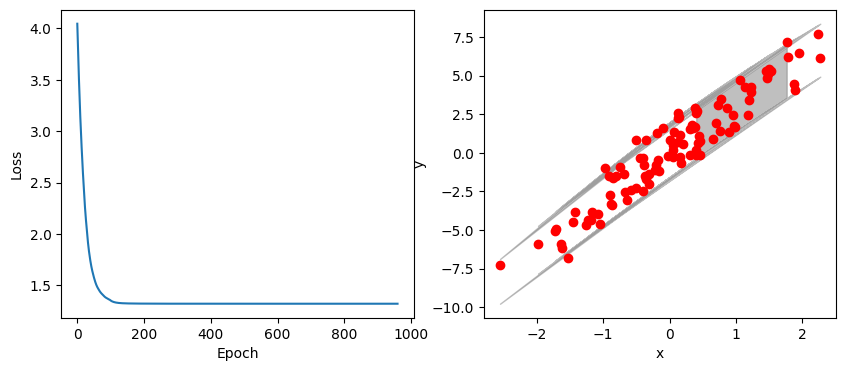

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 生成一些模拟数据
np.random.seed(0)
x = np.random.normal(0, 1, size=(100, 1))
y = 3 * x + np.random.normal(0, 1, size=(100, 1))
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# 定义模型
class PolynomialRegressor(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        self.coefficients_mean = nn.Parameter(torch.randn(degree + 1))  # 预测均值的系数
        self.coefficients_std = nn.Parameter(torch.randn(degree + 1))  # 预测标准差的系数

    def forward(self, x):
        mean = sum(self.coefficients_mean[i] * x.pow(i) for i in range(self.degree + 1))
        std = torch.exp(sum(self.coefficients_std[i] * x.pow(i) for i in range(self.degree + 1)))  # 确保标准差为正
        return mean, std

# 训练模型
model = PolynomialRegressor(degree=2)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# 训练模型并记录每个epoch的损失
losses = []
for epoch in range(1000):
    optimizer.zero_grad()
    mean, std = model(x_tensor)
    # print(x_tensor)
    # print(y_tensor)
    loss = criterion(mean, y_tensor) + criterion(std, torch.abs(y_tensor - mean))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# 打印模型的系数
print("Coefficients for mean:")
for i, coef in enumerate(model.coefficients_mean):
    print(f"a{i}: {coef.item()}")

print("Coefficients for std:")
for i, coef in enumerate(model.coefficients_std):
    print(f"a{i}: {coef.item()}")


# 绘制损失随epoch变化的图像
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses[40:])
plt.xlabel('Epoch')
plt.ylabel('Loss')


# 生成预测区间
with torch.no_grad():
    mean, std = model(x_tensor)
    lower_bound = mean - 1.96 * std
    upper_bound = mean + 1.96 * std

# 绘制数据预测的区间和真实值的图像
plt.subplot(1, 2, 2)
plt.fill_between(x_tensor.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.5)  # 预测区间
plt.scatter(x, y, color='red')  # 真实值
plt.xlabel('x')
plt.ylabel('y')
plt.show()




Epoch 1, Loss: 5.796380996704102


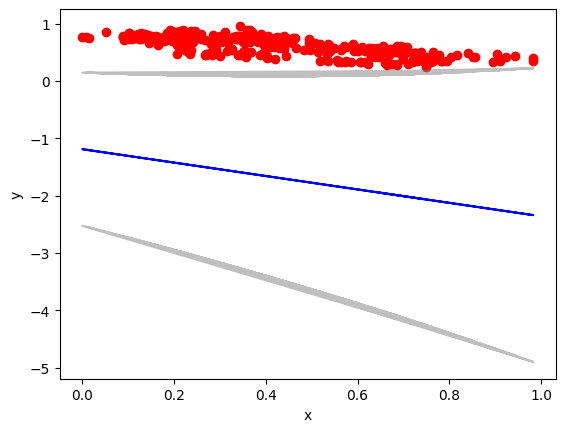

Coefficients for mean:
a0: -1.189784288406372
a1: -1.1702669858932495
Coefficients for std:
a0: -0.3831411302089691
a1: 0.6618293523788452
Average validation loss: 7.148061165442834


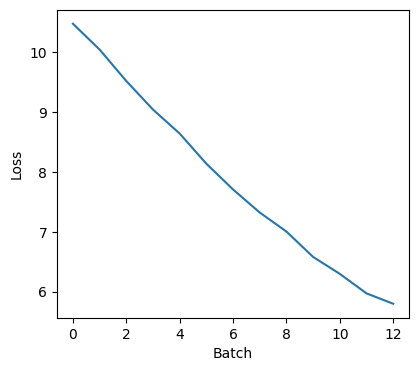

In [25]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from power_plant_dataset import PowerPlantDataset
dataset = PowerPlantDataset(csv_file='fdcl/split/df_hdrm.csv')
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_dataloader = DataLoader(dataset, batch_size=500, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(dataset, batch_size=500, shuffle=True, num_workers=4)

# 定义模型
class PolynomialRegressor(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        self.coefficients_mean = nn.Parameter(torch.randn(degree + 1))  # 预测均值的系数
        self.coefficients_std = nn.Parameter(torch.randn(degree + 1))  # 预测标准差的系数

    def forward(self, x):
        mean = sum(self.coefficients_mean[i] * x.pow(i) for i in range(self.degree + 1))
        std = torch.exp(sum(self.coefficients_std[i] * x.pow(i) for i in range(self.degree + 1)))  # 确保标准差为正
        return mean, std

# 训练模型
model = PolynomialRegressor(degree=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# 训练模型并记录每个epoch的损失
losses = []
for epoch in range(1):
    for i, data in enumerate(train_dataloader):
        # 清零梯度
        optimizer.zero_grad()

        # 前向 + 后向 + 优化
        
        inputs, labels = data
        # print(inputs)
        mean, std = model(inputs)
        # print(labels)
        loss = criterion(mean, labels) + 0.1 * criterion(std, torch.abs(labels - mean))
        #让模型不仅能预测出均值，还预测出预测值的不确定性（通过标准差表示）
        loss.backward()
        optimizer.step()
        # print(loss)
        # 记录损失
        losses.append(loss.item())

        
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        # 生成预测区间
        with torch.no_grad():
            mean, std = model(inputs)
            lower_bound = mean - 1.96 * std
            upper_bound = mean + 1.96 * std
        # 计算预测值的95%置信区间
        
        # 画出上界线
        plt.plot(inputs, upper_bound.flatten(), color='gray', alpha=0.5)
        
        # 画出下界线
        plt.plot(inputs, lower_bound.flatten(), color='gray', alpha=0.5)
        
        # 画出下界线
        plt.plot(inputs, mean, color='blue')
        plt.scatter(inputs, labels, color='red')  # 真实值
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        
# 打印模型的系数
print("Coefficients for mean:")
for i, coef in enumerate(model.coefficients_mean):
    print(f"a{i}: {coef.item()}")

print("Coefficients for std:")
for i, coef in enumerate(model.coefficients_std):
    print(f"a{i}: {coef.item()}")
    
# 绘制损失随epoch变化的图像
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')



# 测试模型并记录每个批次的损失
valid_losses = []
model.eval()  # 切换模型到评估模式
with torch.no_grad():  # 关闭梯度计算
    for i, data in enumerate(valid_dataloader):
        # 前向计算
        inputs, labels = data
        # print(inputs)
        mean, std = model(inputs)

        loss = criterion(mean, labels) + criterion(std, torch.abs(labels - mean))

        # 记录损失
        valid_losses.append(loss.item())

# 计算平均损失
avg_valid_loss = np.mean(valid_losses)
print(f'Average validation loss: {avg_valid_loss}')


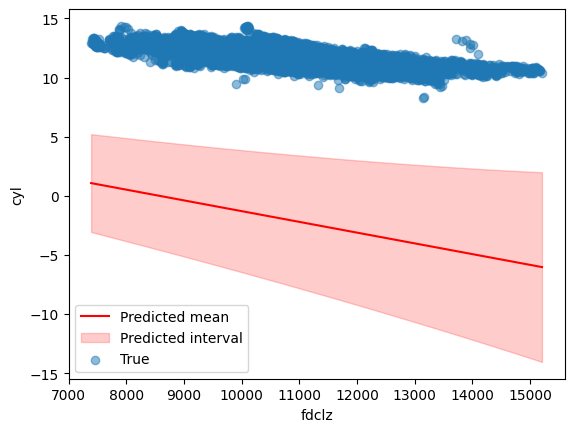

In [26]:
# 用于存储dataset值的列表
features_list = []
real_outputs = []

# 遍历数据集
for i in range(len(dataset)):
    # 获取特征和标签
    features, label = dataset[i]

    # 将特征和标签添加到dataset值列表
    features_list.append(features.item())
    real_outputs.append(label.item())

# 将真实值逆向标准化
real_features_list = dataset.inverse_transform_features(np.array(features_list).reshape(-1, 1))
real_outputs = dataset.inverse_transform_labels(np.array(real_outputs).reshape(-1, 1))

# 根据特征值对真实值进行排序
sorted_indices = np.argsort(real_features_list, axis=0).flatten()
real_features_list = real_features_list[sorted_indices]
real_outputs = real_outputs[sorted_indices]

# 创建一个新的特征数组，用于模型预测
new_features = np.linspace(min(features_list), max(features_list), 500).reshape(-1, 1)

# 将numpy数组转换为PyTorch张量
new_features_torch = torch.from_numpy(new_features).float()

# 使用模型进行预测
mean, std = model(new_features_torch)

# 将预测值逆向标准化
low = dataset.inverse_transform_labels((mean-std).detach().numpy())
upper = dataset.inverse_transform_labels((mean+std).detach().numpy())
mean = dataset.inverse_transform_labels((mean).detach().numpy())

# 逆向标准化新的特征数组，用于绘图
new_features_real = dataset.inverse_transform_features(new_features)

# 绘制预测的均值和区间
plt.plot(new_features_real, mean, 'r-', label='Predicted mean')
plt.fill_between(new_features_real.flatten(), low.flatten(), upper.flatten(), color='r', alpha=0.2, label='Predicted interval')

# 绘制真实值
plt.scatter(real_features_list, real_outputs, label='True', alpha=0.5)

plt.xlabel('fdclz')
plt.ylabel('cyl')
plt.legend()
plt.show()


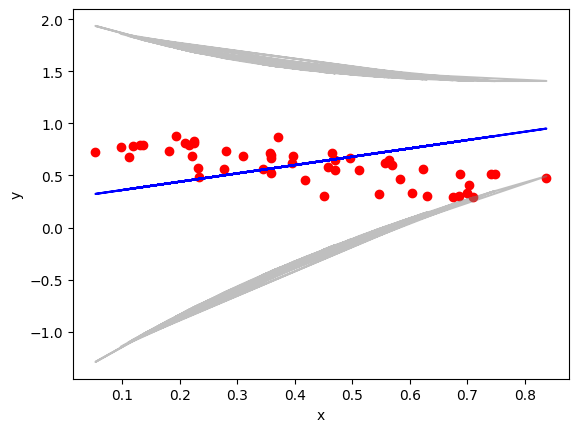